In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=ebbcb3b54490f317c353842b6711cf2a141573dcc345ce8e85aabf3ebad1e748
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("Miniproject").getOrCreate()

In [ ]:
df=spark.read.csv("/content/Traffic.csv",header=True,inferSchema=True)
df.show(5,truncate=False)

+-----------+----+---------------+--------+---------+--------+----------+-----+-----------------+
|Time       |Date|Day of the week|CarCount|BikeCount|BusCount|TruckCount|Total|Traffic Situation|
+-----------+----+---------------+--------+---------+--------+----------+-----+-----------------+
|12:00:00 AM|10  |Tuesday        |31      |0        |4       |4         |39   |low              |
|12:15:00 AM|10  |Tuesday        |49      |0        |3       |3         |55   |low              |
|12:30:00 AM|10  |Tuesday        |46      |0        |3       |6         |55   |low              |
|12:45:00 AM|10  |Tuesday        |51      |0        |2       |5         |58   |low              |
|1:00:00 AM |10  |Tuesday        |57      |6        |15      |16        |94   |normal           |
+-----------+----+---------------+--------+---------+--------+----------+-----+-----------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

In [ ]:
day_indexer = StringIndexer(inputCol="Day of the week", outputCol="DayIndex")
day_model = day_indexer.fit(df)
df = day_model.transform(df)

In [ ]:
traffic_indexer = StringIndexer(inputCol="Traffic Situation", outputCol="TrafficIndex")
traffic_model = traffic_indexer.fit(df)
df = traffic_model.transform(df)

In [ ]:
df.show(5)

+-----------+----+---------------+--------+---------+--------+----------+-----+-----------------+--------+------------+
|       Time|Date|Day of the week|CarCount|BikeCount|BusCount|TruckCount|Total|Traffic Situation|DayIndex|TrafficIndex|
+-----------+----+---------------+--------+---------+--------+----------+-----+-----------------+--------+------------+
|12:00:00 AM|  10|        Tuesday|      31|        0|       4|         4|   39|              low|     1.0|         3.0|
|12:15:00 AM|  10|        Tuesday|      49|        0|       3|         3|   55|              low|     1.0|         3.0|
|12:30:00 AM|  10|        Tuesday|      46|        0|       3|         6|   55|              low|     1.0|         3.0|
|12:45:00 AM|  10|        Tuesday|      51|        0|       2|         5|   58|              low|     1.0|         3.0|
| 1:00:00 AM|  10|        Tuesday|      57|        6|      15|        16|   94|           normal|     1.0|         0.0|
+-----------+----+---------------+------

In [ ]:
columns_to_drop = ["Time", "Day of the week", "Traffic Situation"]
df = df.drop(*columns_to_drop)

In [ ]:
df.show(5)

+----+--------+---------+--------+----------+-----+--------+------------+
|Date|CarCount|BikeCount|BusCount|TruckCount|Total|DayIndex|TrafficIndex|
+----+--------+---------+--------+----------+-----+--------+------------+
|  10|      31|        0|       4|         4|   39|     1.0|         3.0|
|  10|      49|        0|       3|         3|   55|     1.0|         3.0|
|  10|      46|        0|       3|         6|   55|     1.0|         3.0|
|  10|      51|        0|       2|         5|   58|     1.0|         3.0|
|  10|      57|        6|      15|        16|   94|     1.0|         0.0|
+----+--------+---------+--------+----------+-----+--------+------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
feature_columns = ["Date", "CarCount", "BikeCount", "BusCount", "TruckCount", "Total", "DayIndex"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")


In [ ]:
rf = RandomForestClassifier(featuresCol="features", labelCol="TrafficIndex", numTrees=100, maxDepth=4, seed=123)

In [ ]:
pipeline = Pipeline(stages=[assembler, rf])

In [ ]:
train_data, test_data = df.randomSplit([0.7, 0.3], seed=123)
model = pipeline.fit(train_data)
predictions = model.transform(test_data)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="TrafficIndex", predictionCol="prediction", metricName="accuracy")
accuracy0 = evaluator.evaluate(predictions)

print("RandomForestClassifier:", accuracy0)

RandomForestClassifier: 0.9677072120559742


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier(featuresCol="features", labelCol="TrafficIndex", maxDepth=4, seed=123)


In [ ]:
pipeline = Pipeline(stages=[assembler, dt])

In [ ]:
train_data, test_data = df.randomSplit([0.7, 0.3], seed=123)
model1 = pipeline.fit(train_data)
predictions = model1.transform(test_data)

In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="TrafficIndex", predictionCol="prediction", metricName="accuracy"
)
accuracy1 = evaluator.evaluate(predictions)

print("Decision Tree Accuracy:", accuracy1)

Decision Tree Accuracy: 0.9655543595263725


In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
lr = LogisticRegression(featuresCol="features", labelCol="TrafficIndex")

In [ ]:
pipeline = Pipeline(stages=[assembler, lr])

In [ ]:
train_data, test_data = df.randomSplit([0.7, 0.3], seed=123)
model2 = pipeline.fit(train_data)
predictions = model2.transform(test_data)

In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="TrafficIndex", predictionCol="prediction", metricName="accuracy"
)
accuracy2 = evaluator.evaluate(predictions)

print("Logistic Regression Accuracy:", accuracy2)

Logistic Regression Accuracy: 0.8966630785791173


In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [ ]:
num_classes = 4
layers = [7, 10, 5, num_classes]

In [ ]:
train_data.select("TrafficIndex").distinct().show()

+------------+
|TrafficIndex|
+------------+
|         0.0|
|         1.0|
|         3.0|
|         2.0|
+------------+



In [ ]:
mlp = MultilayerPerceptronClassifier(featuresCol="features", labelCol="TrafficIndex", layers=layers, blockSize=128, seed=123)

In [ ]:
pipeline = Pipeline(stages=[assembler, mlp])

In [ ]:
train_data, test_data = df.randomSplit([0.7, 0.3], seed=123)
model3 = pipeline.fit(train_data)
predictions = model3.transform(test_data)

In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="TrafficIndex", predictionCol="prediction", metricName="accuracy"
)
accuracy3 = evaluator.evaluate(predictions)

print("Multilayer Perceptron Accuracy:", accuracy3)

Multilayer Perceptron Accuracy: 0.635091496232508


In [ ]:
from pyspark.ml.classification import NaiveBayes

In [ ]:
nb = NaiveBayes(featuresCol="features", labelCol="TrafficIndex", smoothing=1.0, modelType="multinomial")

In [ ]:
pipeline = Pipeline(stages=[assembler, nb])

In [ ]:
train_data, test_data = df.randomSplit([0.7, 0.3], seed=123)
model4 = pipeline.fit(train_data)
predictions = model4.transform(test_data)

In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="TrafficIndex", predictionCol="prediction", metricName="accuracy"
)
accuracy4 = evaluator.evaluate(predictions)
print("Naive Bayes Accuracy:", accuracy4)

Naive Bayes Accuracy: 0.6523143164693218


**Hyper parameter**

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
feature_columns = ["Date", "CarCount", "BikeCount", "BusCount", "TruckCount", "Total", "DayIndex"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df)
train_data, test_data = data.randomSplit([0.7, 0.3], seed=123)
nb = NaiveBayes(featuresCol="features", labelCol="TrafficIndex")
paramGrid = (ParamGridBuilder()
    .addGrid(nb.smoothing, [0.0, 1.0, 5.0, 10.0])
    .build())
evaluator = MulticlassClassificationEvaluator(
    labelCol="TrafficIndex", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(
    estimator=nb,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5)
cv_model = crossval.fit(train_data)
best_model = cv_model.bestModel
predictions = best_model.transform(test_data)
accuracyh1 = evaluator.evaluate(predictions)
print("Best Naive Bayes Model Accuracy:", accuracyh1)

Best Naive Bayes Model Accuracy: 0.6523143164693218


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
feature_columns = ["Date", "CarCount", "BikeCount", "BusCount", "TruckCount", "Total", "DayIndex"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df)
train_data, test_data = data.randomSplit([0.7, 0.3], seed=123)
dt = DecisionTreeClassifier(featuresCol="features", labelCol="TrafficIndex", maxDepth=4, seed=123)
paramGrid = (ParamGridBuilder()
    .addGrid(dt.maxDepth, [4, 6, 8])
    .build())

evaluator = MulticlassClassificationEvaluator(
    labelCol="TrafficIndex", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(
    estimator=dt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)
cv_model = crossval.fit(train_data)
best_model = cv_model.bestModel
predictions = best_model.transform(test_data)
accuracyh3 = evaluator.evaluate(predictions)
print("Best DecisionTreeClassifier Accuracy:", accuracyh3)


Best DecisionTreeClassifier Accuracy: 0.9687836383207751


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
feature_columns = ["Date", "CarCount", "BikeCount", "BusCount", "TruckCount", "Total", "DayIndex"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df)
train_data, test_data = data.randomSplit([0.7, 0.3], seed=123)
rf = RandomForestClassifier(featuresCol="features", labelCol="TrafficIndex", numTrees=100, maxDepth=4, seed=123)
paramGrid = (ParamGridBuilder()
    .addGrid(rf.numTrees, [100, 200, 300])
    .addGrid(rf.maxDepth, [4, 6, 8])
    .build())
evaluator = MulticlassClassificationEvaluator(
    labelCol="TrafficIndex", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)
cv_model = crossval.fit(train_data)
best_model = cv_model.bestModel
predictions = best_model.transform(test_data)
accuracy = evaluator.evaluate(predictions)
print("Best RandomForestClassifier Accuracy:", accuracy)


Best RandomForestClassifier Accuracy: 0.9773950484391819


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
feature_columns = ["Date", "CarCount", "BikeCount", "BusCount", "TruckCount", "Total", "DayIndex"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df)
train_data, test_data = data.randomSplit([0.7, 0.3], seed=123)
lr = LogisticRegression(featuresCol="features", labelCol="TrafficIndex", maxIter=10, regParam=0.01, elasticNetParam=0.8)
paramGrid = (ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.1, 1.0])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .build())
evaluator = MulticlassClassificationEvaluator(
    labelCol="TrafficIndex", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)
cv_model = crossval.fit(train_data)
best_model = cv_model.bestModel
predictions = best_model.transform(test_data)
accuracyh2 = evaluator.evaluate(predictions)
print("Best Logistic Regression Accuracy:", accuracyh2)


Best Logistic Regression Accuracy: 0.8665231431646933


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
feature_columns = ["Date", "CarCount", "BikeCount", "BusCount", "TruckCount", "Total", "DayIndex"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df)
train_data, test_data = data.randomSplit([0.7, 0.3], seed=123)
layers = [len(feature_columns), 10, 10, 5]
mlp = MultilayerPerceptronClassifier(featuresCol="features", labelCol="TrafficIndex", layers=layers, blockSize=128, seed=123)
paramGrid = (ParamGridBuilder()
    .addGrid(mlp.maxIter, [100, 200])
    .addGrid(mlp.stepSize, [0.03, 0.1])
    .build())
evaluator = MulticlassClassificationEvaluator(
    labelCol="TrafficIndex", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(
    estimator=mlp,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)
cv_model = crossval.fit(train_data)
best_model = cv_model.bestModel
predictions = best_model.transform(test_data)
accuracyh4= evaluator.evaluate(predictions)
print("Best MLP Classifier Accuracy:", accuracyh4)

Best MLP Classifier Accuracy: 0.759956942949408


In [ ]:
rf=accuracy*100
nb=accuracyh1*100
dt=accuracyh3*100
mlp=accuracyh4*100
lr=accuracyh2*100

In [ ]:
acc=[rf,nb,dt,mlp,lr]
models=['rf','nb','dt','mlp','lr']

Hyperparameter Graph

<Axes: xlabel='algorithm', ylabel='accuracy'>

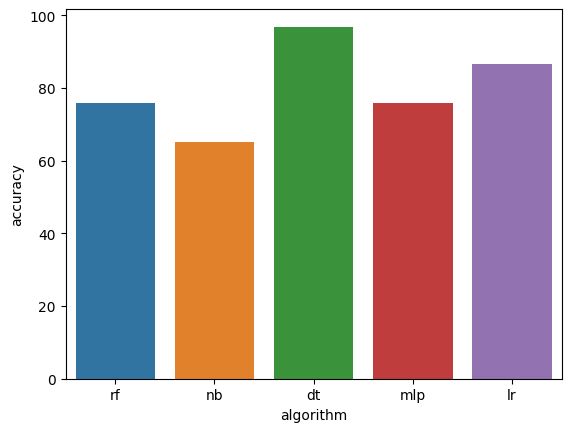

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.barplot(data=pd.DataFrame({"algorithm":models,"accuracy":acc}),x="algorithm",y="accuracy")

In [ ]:
rf=accuracy0*100
nb=accuracy4*100
dt=accuracy1*100
mlp=accuracy3*100
lr=accuracy2*100

In [ ]:
acc=[rf,nb,dt,lr,mlp]
models=['rf','nb','dt','lr','mlp']

Graph

<Axes: xlabel='alg', ylabel='accuracy'>

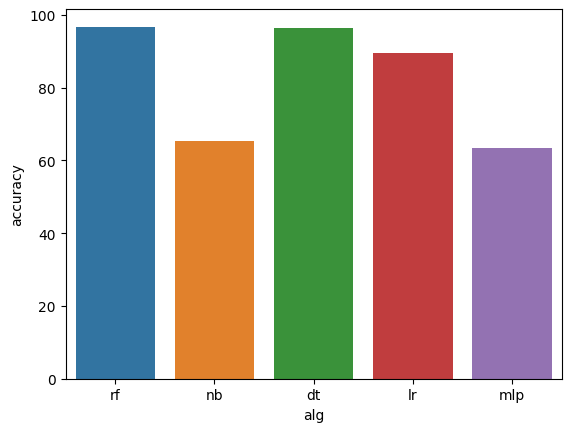

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.barplot(data=pd.DataFrame({"alg":models,"accuracy":acc}),x="alg",y="accuracy")